# Baseline model

## ARIMA Model

In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
%load_ext autoreload
%autoreload 2

### Import data

In [3]:
from electricity_price_predictor.data_2 import get_price, get_shifted_price

In [4]:
df= get_shifted_price()
df.head()

,price
time,
2015-01-01 00:00:00,25.02
2015-01-01 01:00:00,18.29
2015-01-01 02:00:00,16.04
2015-01-01 03:00:00,14.60
2015-01-01 04:00:00,14.95


### Decomposition of hourly data

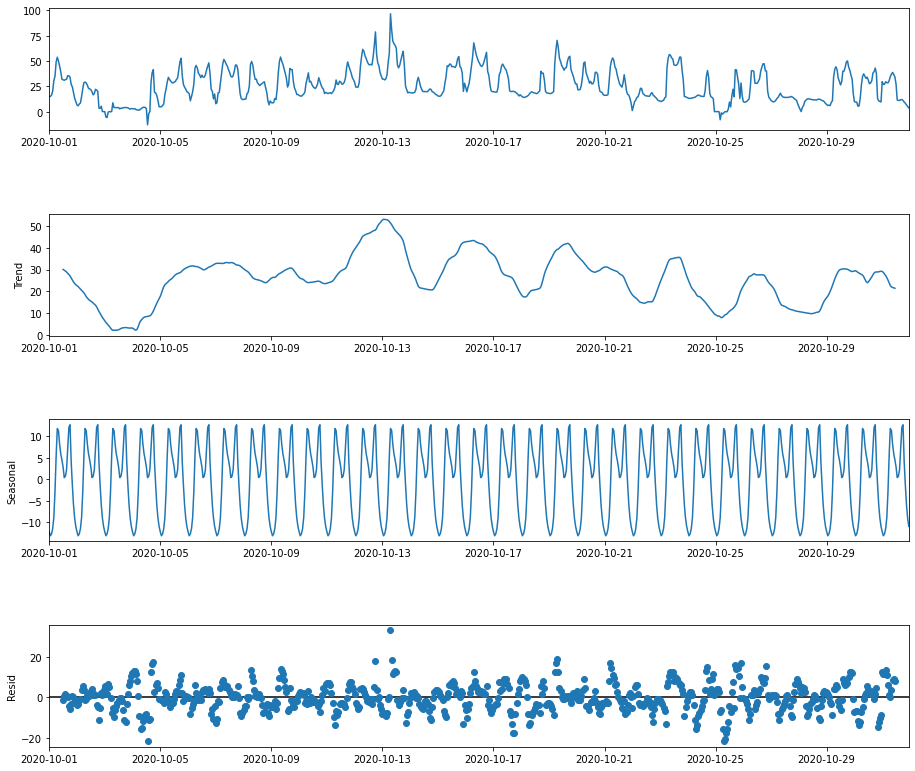

In [19]:
df_2020_10 = df[(df.index.year==2020) & (df.index.month==10)]
decompose_2020_10 = seasonal_decompose(df_2020_10, model='additive')
fig = decompose_2020_10.plot()
fig.set_size_inches(14, 12);

### Decomposition of df_hour_11

In [5]:
# get all the data for 11 am 
df_hour_11 = df[df.index.hour==11]
df_hour_11.head()

,price
time,
2015-01-01 11:00:00,16.08
2015-01-02 11:00:00,15.08
2015-01-03 11:00:00,22.31
2015-01-04 11:00:00,27.32
2015-01-05 11:00:00,40.97


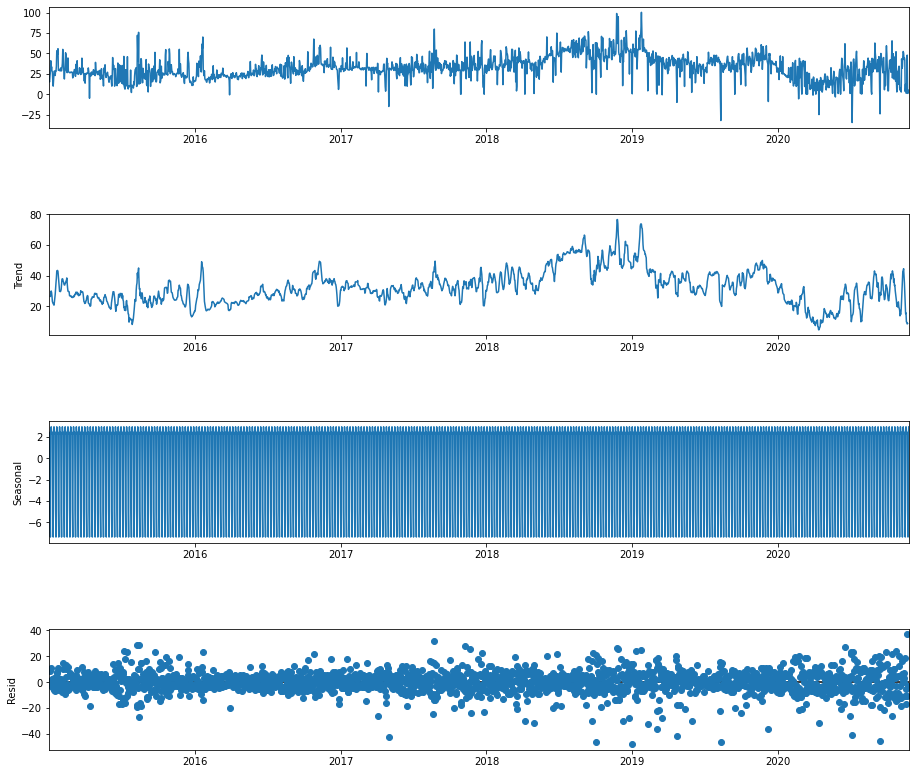

In [6]:
# for 5 years
decompose_5y = seasonal_decompose(df_hour_11, model='additive')
fig = decompose_5y.plot()
fig.set_size_inches(14, 12);

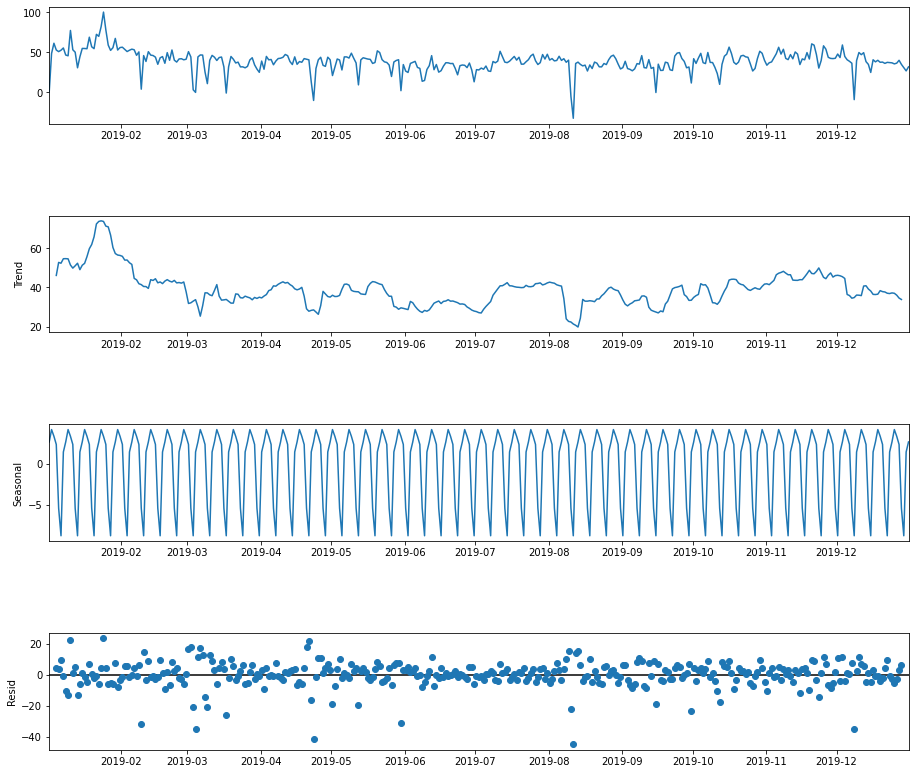

In [30]:
# for year 2019 
decompose_2019 = seasonal_decompose(df_hour_11[(df_hour_11.index.year==2019)], model='additive')
fig = decompose_2019.plot()
fig.set_size_inches(14, 12);

- No clear monthly or yearly seasonality is observed.
- There is a clear weekly seasonality, which is likely caused by electricity usage in household

### Explore the stationarity

In [11]:
# remove the weekly seasonality
df_hour_11_deseasonalized = pd.DataFrame((df_hour_11.price - decompose_5y.seasonal), columns=['price'])

Text(0.5, 1.0, 'First order diff of deseasonalized series')

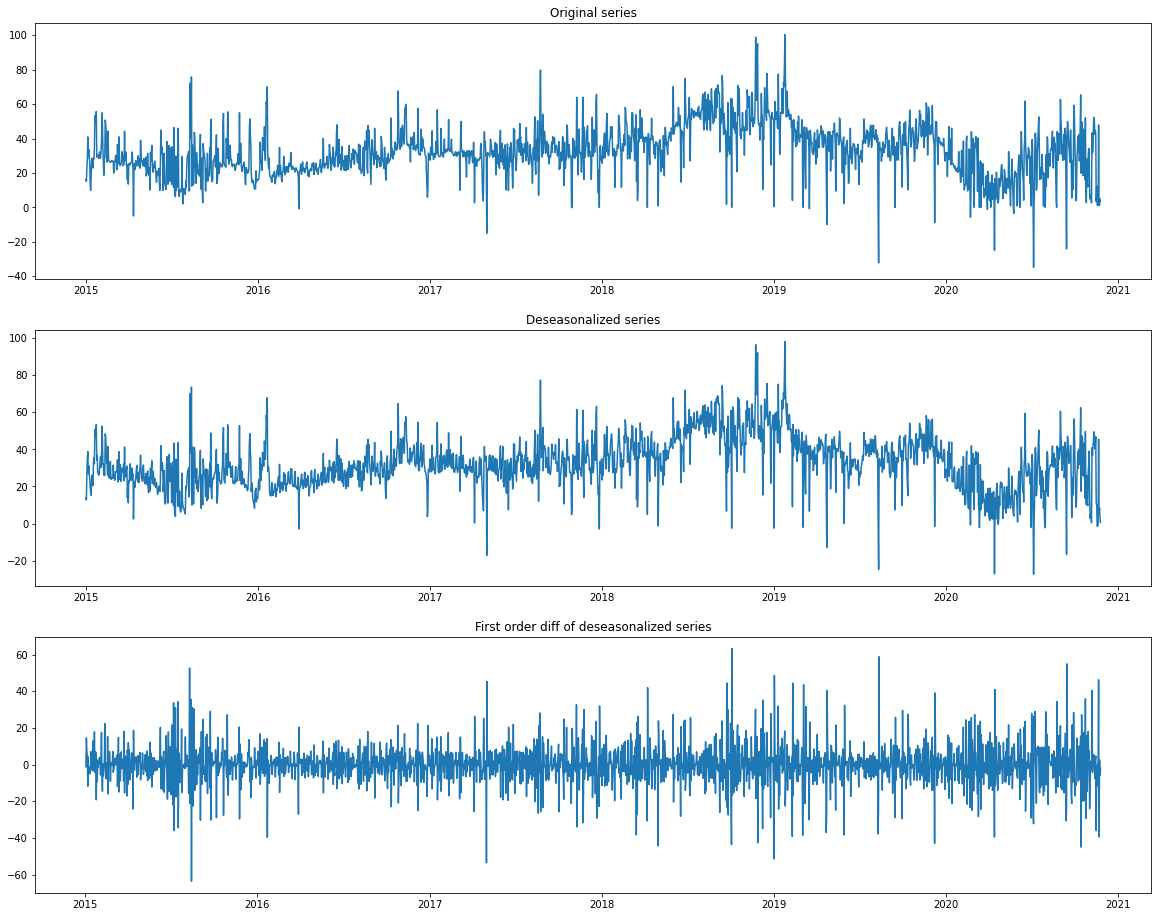

In [21]:
# Explore stationarity of deseasonalized data

fig, axs = plt.subplots(3, 1, figsize=(20,16))
# Original series
axs[0].plot(df_hour_11)
axs[0].set_title('Original series')

# Deseasonalized Series
axs[1].plot(df_hour_11_deseasonalized) 
axs[1].set_title('Deseasonalized series')

# Week + Normal differencing
axs[2].plot(df_hour_11_deseasonalized.diff(1))
axs[2].set_title('First order diff of deseasonalized series')

In [26]:
# ADF test
print('ADF of deseasonalized data: ', adfuller(df_hour_11_deseasonalized)[1])
print('ADF of first order diff deseasonalized data: ', adfuller(df_hour_11_deseasonalized.diff(1).dropna())[1])

ADF of deseasonalized data:  0.012980883598311095
ADF of first order diff deseasonalized data:  1.0245879216687705e-27


### Autocorrelation

#### Original series

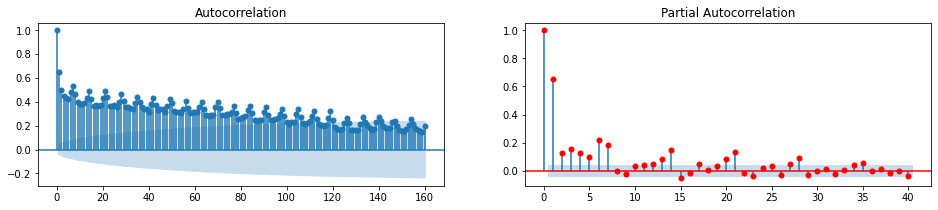

In [32]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11, lags=160, ax=axes[0]);
plot_pacf(df_hour_11, lags=40, ax=axes[1], color='r');

- ACF shows weekly seasonality and one timepoint is correlated with pass 120 timepoints even more
- PACF also shows weekly seasonality

#### After removing weekly seasonality

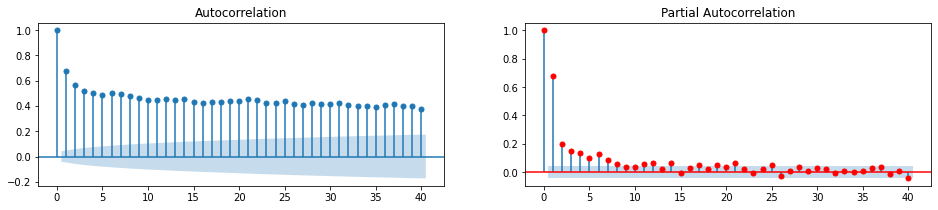

In [33]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized, lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized, lags=40, ax=axes[1], color='r');

- Both ACF show slow gradual decrease, should consider first order diff 

#### After removing weekly seasonality and perform first order diff

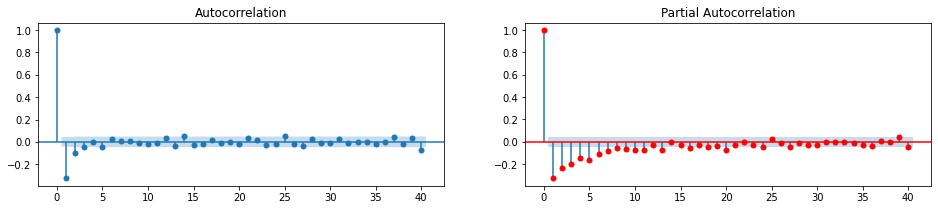

In [34]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[1], color='r');

- According to ACF and PACF, (p, d, q) = (3~7, 1, 1) 

### ARIMA model based on ACF and PACF

In [42]:
# grid search the hyper params
import pmdarima as pm
smodel = pm.auto_arima(df_hour_11_deseasonalized, seasonal=False, 
                       start_p=0, max_p=2, 
                       d=1,
                       start_q=0, max_q=2, 
                       trace=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16482.645, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16240.949, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15981.304, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16480.645, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15812.132, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15813.193, Time=1.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15813.141, Time=1.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15842.135, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16122.693, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15813.924, Time=2.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15810.163, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15979.315, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16238.950, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15811.224, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0

In [36]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(df_hour_11_deseasonalized, order=(1,1,1), freq='D')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 2154
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7902.066
Method:                       css-mle   S.D. of innovations              9.481
Date:                Thu, 26 Nov 2020   AIC                          15812.132
Time:                        19:55:48   BIC                          15834.832
Sample:                    01-02-2015   HQIC                         15820.436
                         - 11-24-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0038      0.022     -0.175      0.861      -0.047       0.039
ar.L1.D.price     0.3676      0.024     15.146      0.000       0.320       0.415
ma.L1.D.price    -0.9329      0.010    -88.935      0.000      -0.953      -0.912
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.7201           +0.0000j            2.7201            0.0000
MA.1            1.0719           +0.0000j            1.0719            0.0000
-----------------------------------------------------------------------------
"""

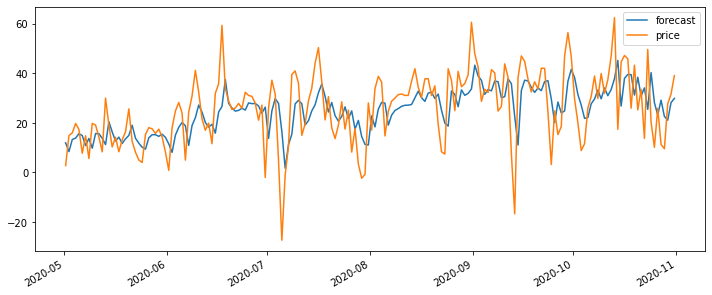

In [39]:
arima.plot_predict('2020-05', '2020-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

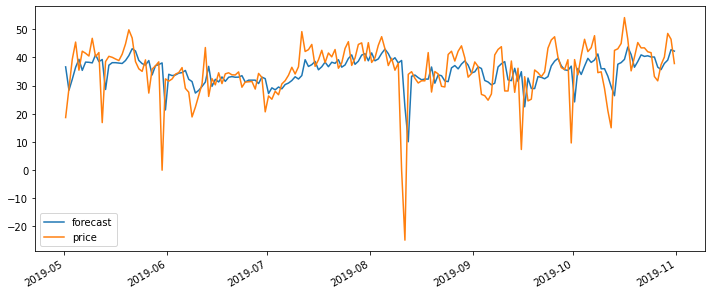

In [40]:
arima.plot_predict('2019-05', '2019-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

### Evaluate the model

In [212]:
# Create a correct Training/Test split to predict the last 50 points
train = df_hour_11[df_hour_11.index <= '2019-10-22 11:00:00']
test = df_hour_11[(df_hour_11.index > '2019-10-22 11:00:00') & \
                  (df_hour_11.index < '2019-11-20 11:00:00')]

In [213]:
train

,price
time,
2015-01-01 11:00:00,16.08
2015-01-02 11:00:00,15.08
2015-01-03 11:00:00,22.31
2015-01-04 11:00:00,27.32
2015-01-05 11:00:00,40.97
...,...
2019-10-18 11:00:00,37.66
2019-10-19 11:00:00,35.20
2019-10-20 11:00:00,37.90


In [214]:
# Decomposition
decompose = seasonal_decompose(train, model='additive')
train_decompose = pd.DataFrame((train.price - decompose.seasonal), columns=['price'])

In [215]:
# Train the Model
arima = ARIMA(train_decompose, order=(1, 1, 1), freq='D')
arima = arima.fit()
# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

In [216]:
# define a function for re-compose forecast and confident-intervals

def re_compose(forecast, confidence_int):
    '''take forecast price and confidence_intervals as input, returns re-composed forecast price and confident_int'''
    forecast = pd.DataFrame(forecast, index=test.index, columns=['price'])
    forecast['upper_int'] = confidence_int[:,0] 
    forecast['lower_int'] = confidence_int[:,1]
    forecast['dayofweek'] = forecast.index.dayofweek
    # get the base price of day of week
    week_price = decompose.seasonal.to_frame().set_index(decompose.seasonal.index.dayofweek).drop_duplicates()
    # add the base price to the forecast price
    for i in range(7):
        value = week_price.loc[i, 'seasonal']
        forecast[forecast.dayofweek == i] = forecast[forecast.dayofweek == i] +value
        forecast['dayofweek'] = forecast.index.dayofweek
    forecast.drop(columns=['dayofweek'], inplace=True)
    return forecast    

In [217]:
# define a function for plotting the forecast

def plot_forecast(forecast, train, test, confidence_int):
    fc = re_compose(forecast, confidence_int)
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc.price, label='forecast', color='orange')
    plt.fill_between(fc.index, fc.lower_int, fc.upper_int, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

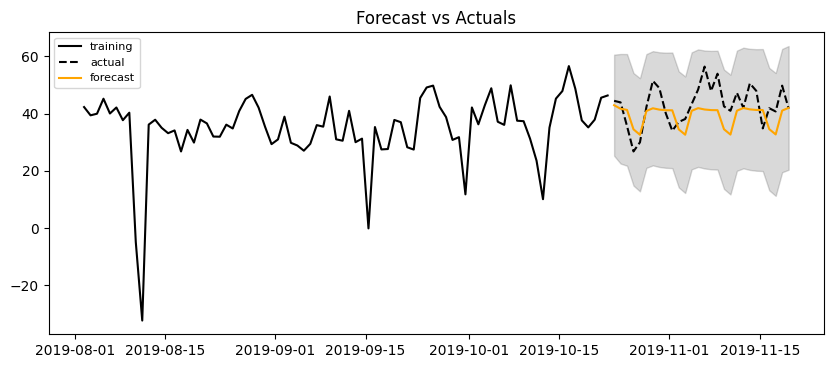

In [221]:
# plot the forecast
plot_forecast(forecast, train[train.index > '2019-08-1 11:00:00'], test, confidence_int)

In [222]:
# define a function for MAPE
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return f'{mape}%' 

In [224]:
get_mape(forecast, test) # this was near 50% for2020

'16.4912337961762%'

## SARIMAX Model

In [ ]:
df_daily_mean.shape

In [ ]:
# Create a correct Training/Test split to predict the last 50 points
train_df = df_daily_mean[:2150]
test_df = df_daily_mean[2150:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train_df,
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test_df), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [ ]:
plot_forecast(forecast, train_df, test_df)

## Inference validity

In [ ]:
## plot residuals to see whether their normal distributed
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(engod=df['electricity_price'],
                 exog=df['day_of_week'],
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

# Prophet

[reference for model_b](https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1)